# LIME

Local Interpretable Model-agnostic Explanations (LIME) is a technique of explaining the predictions of a black box machine learning model by building a number of interpretable local surrogate models (like linear regression). Surrogate models are trained on the predictions of the underlying black box model. 



LIME (Local Interpretable Model-agnostic Explanations) assumes we already have
a trained machine learning model, it is model agnostic.
Let's first create and train a model
  

## Imports

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Data import 

Let's us MNIST data set. To make our example even more clearer, we will classify only between 1 and 7. Usually the hardest to identify due to there similarity in script wrtting. 

In [7]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch

class SubsetMNIST(Dataset):
    def __init__(self, original_dataset, classes=[1, 7]):
        self.data = []
        self.targets = []
        
        # Define the transformation to convert images to tensors
        transform = transforms.Compose([transforms.ToTensor()])
        
        # Filter dataset to only include the classes you want
        for i in range(len(original_dataset)):
            img, label = original_dataset[i]
            if label in classes:
                # Apply the transformation to the image
                img = transform(img)
                
                # Remap labels: 1 -> 0, 7 -> 1
                if label == 1:
                    label = 0
                elif label == 7:
                    label = 1
                
                self.data.append(img)
                self.targets.append(label)
        
        # Convert the list of targets to a tensor
        self.targets = torch.tensor(self.targets)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.data)

# Load the original MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True)
full_test_dataset = datasets.MNIST(root='./data', train=False, download=True)

# Create a subset of the MNIST dataset containing only classes 1 and 7
train_dataset = SubsetMNIST(full_train_dataset, classes=[1, 7])
test_dataset = SubsetMNIST(full_test_dataset, classes=[1, 7])


# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


## Model :

Let's now build our simple CNN model

In [8]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.pool = nn.AvgPool2d(2, 2)  # 28x28 -> 14x14
        self.fc1 = nn.Linear(32 * 14 * 14, 2)  # 32 channels * 14x14 spatial size -> 2 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)  # Pooling to reduce the size
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc1(x)
        return x


### Training 
Let's train it for a few epochs :

In [9]:
# Initialize the model, criterion, and optimizer
model = MNIST_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Set number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch [1/5], Loss: 0.0635
Epoch [2/5], Loss: 0.0146
Epoch [3/5], Loss: 0.0116
Epoch [4/5], Loss: 0.0104
Epoch [5/5], Loss: 0.0079
Training complete!


In [10]:
correct = 0
total = 0
with torch.no_grad():  # No gradients needed for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Accuracy on test set: {accuracy:.2f}%")


Accuracy on test set: 99.72%


### Evaluation : 

Finally let's evaluate to check the robustness of our model

torch.Size([5, 1, 28, 28])


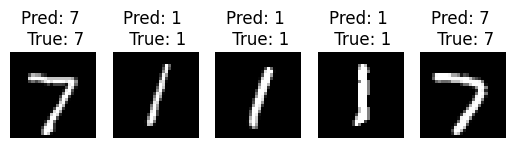

Accuracy on test set: 99.72%


In [11]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

# Get a batch of test data
images, labels = next(iter(test_loader))  # Get a batch of images
outputs = model(images)
print(images.shape)
# Get predicted class indices
_, predicted = torch.max(outputs, 1)

# Plot the first 5 images in the batch with their predicted and true labels
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")  # squeeze to remove unnecessary dimension
    plt.title(f"Pred: {(predicted[i].item())*6+1} \n True: {(labels[i].item())*6+1}")
    plt.axis('off')

plt.show()

# Compute accuracy on the test dataset
correct = 0
total = 0
with torch.no_grad():  # No need to track gradients for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100  # Accuracy as percentage
print(f"Accuracy on test set: {accuracy:.2f}%")



We can now check the wrongly labeled one 

In [12]:
labels

tensor([0, 1, 0])

In [13]:
predicted


tensor([0, 1, 0])

## LIME 

LIME focuses on the locality of the specific instance we want to explain.It does not explore all possible regions of the dataset rather but zooms in on the region near the selected instance. It provides a local explanation.

Around this instance, LIME generates a set of perturbed instances by slightly modifying its features (e.g., flipping binary features, altering numerical values). Meaning LIME is a perturbation based model.

It then maps the data into an interpretable space (e.g., for text, it might use the presence/absence of words; for images, it might use superpixels). This simplification makes the explanation understandable to humans. 

LIME fits a simple, interpretable surrogate model (e.g., a linear regression or decision tree) using the weighted perturbed instances. This model approximates the black-box model's behavior locally around the selected instance.

The interpretable model is trained to mimic the predictions of the black-box model as closely as possible in the vicinity of the instance.



In [38]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import gray2rgb
from skimage.segmentation import mark_boundaries
from sklearn.linear_model import Ridge
import torch.nn.functional as F


def generate_perturbations(image, segments, num_samples=1000):
    num_superpixels = np.max(segments) + 1
    perturbations = np.random.randint(0, 2, size=(num_samples, num_superpixels))
    perturbed_images = []
    image = np.array(image)


    for mask in perturbations:
        temp = image.copy()
        for i in range(num_superpixels):
            if mask[i] == 0:
                temp[segments == i] = 0  # Mask this superpixel
        perturbed_images.append(temp)

    return np.array(perturbations), np.array(perturbed_images)

def explain_lime(image, predict_fn, label, num_samples=1000, num_segments=10):
    # Segment image into superpixels
    segments = slic(gray2rgb(image), n_segments=num_segments, compactness=10, sigma=1, start_label=0)

    # Generate perturbed images and corresponding masks
    perturbations, perturbed_images = generate_perturbations(image, segments, num_samples)

    # Get predictions for perturbed images
    preds = predict_fn(perturbed_images)
    preds_for_label = preds[:, label]

    # Fit a linear model (LIME step)
    model = Ridge(alpha=1, fit_intercept=True)
    model.fit(perturbations, preds_for_label)

    # Get importance weights for superpixels
    weights = model.coef_

    # Create explanation image
    explanation = np.zeros_like(image, dtype=float)
    for i in range(weights.shape[0]):
        explanation[segments == i] = weights[i]

    return segments, explanation

def predict_fn(images_np):
    # images_np: (N, 1, H, W) or (N, H, W)
    if images_np.ndim == 3:  # (N, H, W), add channel dimension
        images_np = images_np[:, np.newaxis, :, :]
    
    images_tensor = torch.tensor(images_np, dtype=torch.float32)
    
    with torch.no_grad():
        outputs = model(images_tensor)          # logits
        probs = F.softmax(outputs, dim=1)       # Convert to probabilities
    
    return probs.cpu().numpy()


In [39]:
# Set model to evaluation mode
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Get a batch of test data
images, labels = next(iter(test_loader)) 

image = images[0].squeeze()
print(np.array(images[0]).shape)

(1, 28, 28)


/tmp/ipykernel_1658/2407435988.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(images[0]).shape)


/tmp/ipykernel_1658/4015107440.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(image)
/tmp/ipykernel_1658/1686888873.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ax[1].imshow(mark_boundaries(np.array(image), segments))


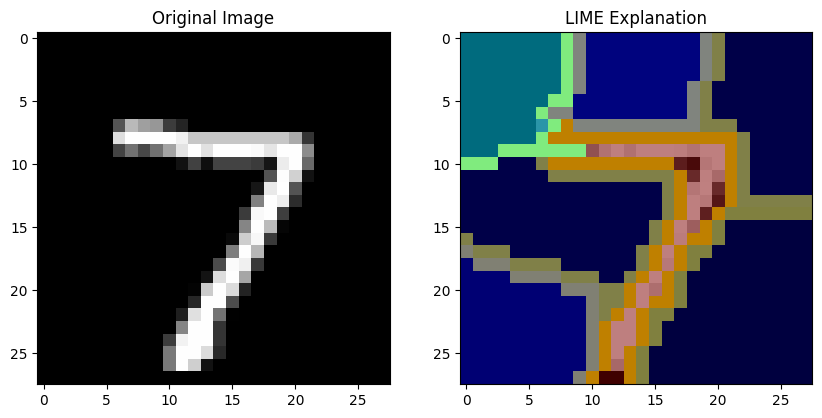

In [43]:
# Set model to evaluation mode
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

# Get a batch of test data
images, labels = next(iter(test_loader)) 

segments, explanation = explain_lime(image, predict_fn, label=1)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(mark_boundaries(np.array(image), segments))
ax[1].imshow(explanation, cmap='jet', alpha=0.5)
ax[1].set_title("LIME Explanation")
plt.show()


1


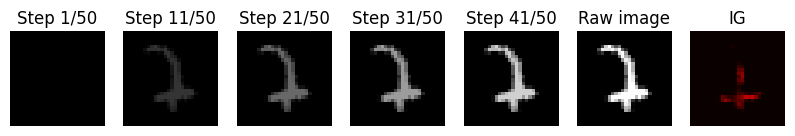

In [67]:
test_image, test_label = test_dataset[278]  # Image wrongly classified

test_image = test_image.unsqueeze(0) 

# Define a zero baseline (black image)
baseline = torch.zeros_like(test_image)

# Get the predicted class for our test image
output = model(test_image)
predicted_class = output.argmax().item()
print(predicted_class*6+1)
# Compute Integrated Gradients
ig_attributions = integrated_gradients(model, test_image, baseline, target_class=predicted_class, steps=50)

1


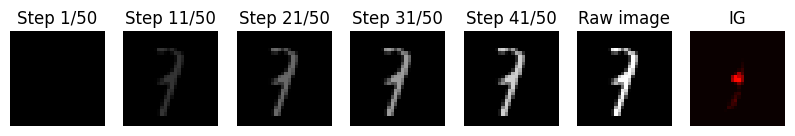

In [66]:
test_image, test_label = test_dataset[329]  # Image wrongly classified

test_image = test_image.unsqueeze(0) 

# Define a zero baseline (black image)
baseline = torch.zeros_like(test_image)

# Get the predicted class for our test image
output = model(test_image)
predicted_class = output.argmax().item()
print(predicted_class*6+1)
# Compute Integrated Gradients
ig_attributions = integrated_gradients(model, test_image, baseline, target_class=predicted_class, steps=50) # Add batch dimension

Remark : 

- In this example we are using grayscale, so we are only computing the gradient of each pixel on one dimension. In case the input is several dimension, the 

- One sanity test to run is to test to check the completeness. The completness property is imply by the sensitivity $\sum_{i=1}^{n}IntegratedGrads(x)=F(x) - F(x')$